# БУСТИНГ

Импорт необходимых библиотек

In [63]:
import sys
import pickle

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from livelossplot import PlotLossesKeras

sys.path.append('../../')

from core.datasets import get_logit_ds

Скачиваем датасеты

In [64]:
train_ds, val_ds = get_logit_ds(['_g_11', '_g_21', '_g_22', '_s_6'])
val_ds_x = np.array([i[0] for i in val_ds.unbatch().as_numpy_iterator()])
val_ds_y = np.array([i[1] for i in val_ds.unbatch().as_numpy_iterator()])

In [89]:
for i in train_ds.take(1):
    print(np.array(i[0][0]))
    print(int(i[1][0]))

[[-13.4016485  -9.070877  -15.873512   -3.3980796]
 [ -3.5677557  -4.534551   -2.733246   -0.7604026]
 [ 20.116537    9.895212   24.19678    10.075061 ]
 [ -1.8975751 -11.410993   -7.6844463  -3.3488624]
 [ -7.8799424 -12.441488  -12.58649    -8.821644 ]
 [-19.667194  -23.070833  -29.640303  -11.96041  ]
 [-21.810843  -15.057429  -24.407597   -8.487006 ]
 [-23.126957  -13.401496  -19.197453   -9.492864 ]
 [-17.59122    -7.6941905 -13.042625   -3.925645 ]
 [-20.516356  -16.52446   -21.284039   -6.795985 ]]
2


Датасет формата:

```python
[[log_1_1, log_1_2, ..., log_1_n],
...
[log_m_1, log_m_2, ..., log_m_n]]
```
где log_i_k - логит модели `k` на картинку `i`


----
Мысли о моделе:

я применяю свертку, размером 1, чтоб один фильтр включал в себя все ответы моделей на 1 изображение

In [66]:
meta_model = tf.keras.Sequential([
    tf.keras.layers.Input((10, 4), 100),
    tf.keras.layers.Conv1D(128, 1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(10),
])
meta_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (100, 10, 128)            640       
                                                                 
 flatten_2 (Flatten)         (100, 1280)               0         
                                                                 
 dense_16 (Dense)            (100, 10)                 12810     
                                                                 
Total params: 13,450
Trainable params: 13,450
Non-trainable params: 0
_________________________________________________________________


In [67]:
num_model = '_G_9'

Чекпоинты

In [68]:
metrics = ['accuracy']
callbacks = [
    PlotLossesKeras(),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/ensemble{num_model}_accuracy.h5',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/ensemble{num_model}_loss.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    ),
    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/ensemble{num_model}_avg_accuracy.h5',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
    ),
    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/ensemble{num_model}_avg_loss.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    )
]

Компилирую модель

In [69]:
meta_model.compile(
    optimizer=tfa.optimizers.MovingAverage(tf.keras.optimizers.legacy.Adam()),
    metrics=metrics,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

Обучаю модель

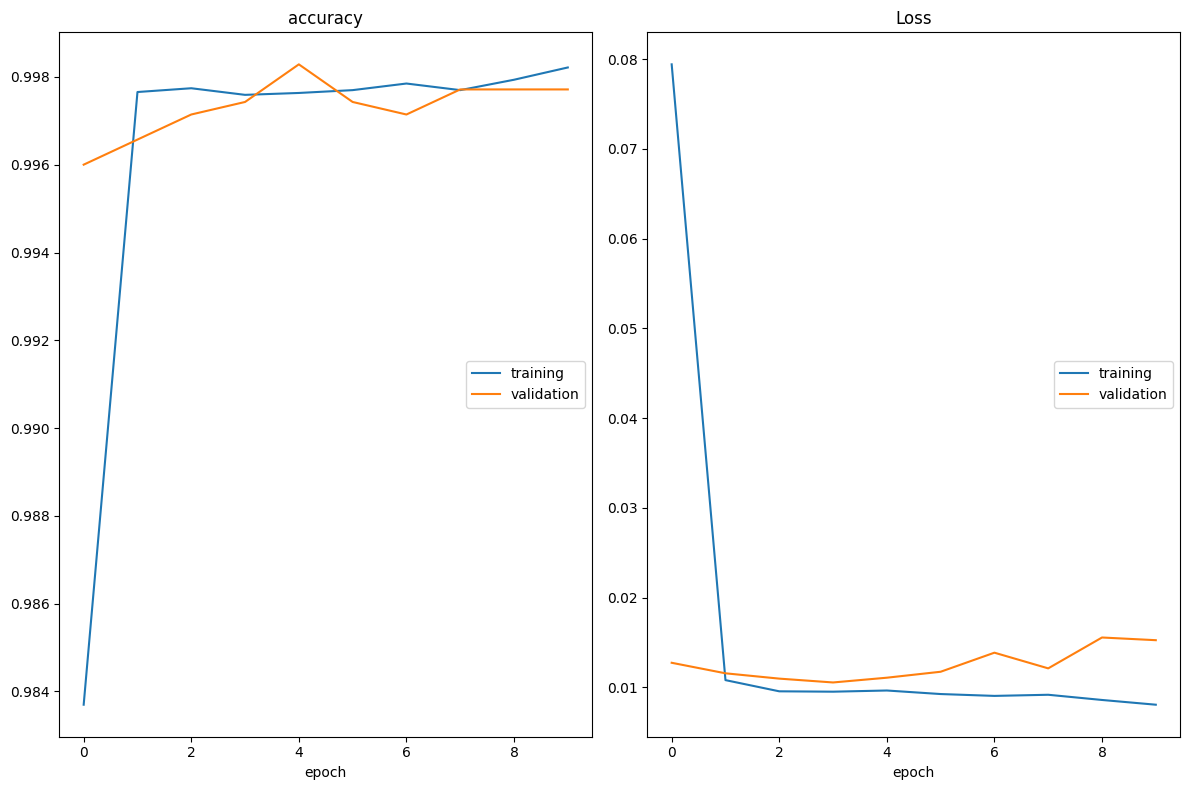

accuracy
	training         	 (min:    0.984, max:    0.998, cur:    0.998)
	validation       	 (min:    0.996, max:    0.998, cur:    0.998)
Loss
	training         	 (min:    0.008, max:    0.079, cur:    0.008)
	validation       	 (min:    0.011, max:    0.016, cur:    0.015)
465/465 [==============================] - 4s 8ms/step - loss: 0.0081 - accuracy: 0.9982 - val_loss: 0.0152 - val_accuracy: 0.9977


In [70]:
history = meta_model.fit(train_ds, validation_data=val_ds,
          epochs=10, callbacks=callbacks, verbose=1)

Скачиваю все чекпоинты

In [71]:
model_acc = tf.keras.models.load_model(f'../checkpoints/ensemble{num_model}_accuracy.h5')
model_loss = tf.keras.models.load_model(f'../checkpoints/ensemble{num_model}_loss.h5')
model_avg_acc = tf.keras.models.load_model(f'../checkpoints/ensemble{num_model}_avg_accuracy.h5')
model_avg_loss = tf.keras.models.load_model(f'../checkpoints/ensemble{num_model}_avg_loss.h5')

Формирую ответы на валидационный датасет

In [72]:
ans_val_accuracy = np.argmax(model_acc.predict(val_ds_x), axis=-1)
ans_val_loss = np.argmax(model_loss.predict(val_ds_x), axis=-1)
ans_val_avg_accuracy = np.argmax(model_avg_acc.predict(val_ds_x), axis=-1)
ans_val_avg_loss = np.argmax(model_avg_loss.predict(val_ds_x), axis=-1)
anss = [ans_val_accuracy, ans_val_loss, model_avg_acc, ans_val_avg_loss]

110/110 [==============================] - 0s 3ms/step


In [73]:
model_acc.predict(val_ds_x)[0]

110/110 [==============================] - 0s 2ms/step


array([ 2.7820022,  7.653935 ,  6.5905604, 11.859014 ,  5.520579 ,
       32.225967 ,  7.9488206, -1.2937067,  7.4968696,  3.978884 ],
      dtype=float32)

In [74]:
for i in range(len(anss) - 1):
    for j in range(i + 1, len(anss)):
        if np.all(anss[i] == anss[j]):
            print(f'чекпоинты {i + 1} и {j + 1} одинаковые')

In [75]:
class MulticlassClassificationMetrics:
    def __init__(self, y_true, y_pred):
        self.y_true = np.array(y_true)
        self.y_pred = np.array(y_pred)
        self.matrix_error = self.get_matrix_error()

    def get_matrix_error(self):
        self.class_types = np.unique([self.y_true, self.y_pred])
        TP, FN, FP, TN = [], [], [], []
        for class_type in self.class_types:
            TP.append(np.sum(np.logical_and(self.y_true == self.y_pred, self.y_true == class_type)))
            FN.append(np.sum(np.logical_and(self.y_true == class_type, self.y_pred != class_type)))
            FP.append(np.sum(np.logical_and(self.y_pred == class_type, self.y_true != class_type)))
            TN.append(np.sum(np.logical_and(self.y_pred != class_type, self.y_true != class_type)))
        return pd.DataFrame({
            'class_type': self.class_types,
            'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
        }).set_index('class_type')

    def accuracy(self):
        return np.sum(self.y_true == self.y_pred) / self.y_true.shape[0]

    def precision(self, averaging='macro'):
        if averaging == 'macro':
            precisions = self.matrix_error['TP'] / (self.matrix_error['TP'] + self.matrix_error['FP'])
            return np.mean(precisions.replace(np.nan, 0))
        elif averaging == 'micro':
            mean_val = self.matrix_error.mean()
            return mean_val['TP'] / (mean_val['TP'] + mean_val['FP'])

    def recall(self, averaging='macro'):
        if averaging == 'macro':
            recalls = self.matrix_error['TP'] / (self.matrix_error['TP'] + self.matrix_error['FN'])
            return np.mean(recalls.replace(np.nan, 0))
        elif averaging == 'micro':
            mean_val = self.matrix_error.mean()
            return mean_val['TP'] / (mean_val['TP'] + mean_val['FN'])

    def f1_score(self, averaging='macro'):
        if averaging == 'macro':
            reverse_r = (self.matrix_error['TP'] + self.matrix_error['FN']) / self.matrix_error['TP']
            reverse_p = (self.matrix_error['TP'] + self.matrix_error['FP']) / self.matrix_error['TP']
            f1_scores = 2 / (reverse_r + reverse_p)
            return np.mean(f1_scores.replace(np.nan, 0))
        elif averaging == 'micro':
            p = self.precision(averaging)
            r = self.recall(averaging)
            return 2 * p * r / (p + r)

    def metrics(self, averaging='macro'):
        return {
            'accuracy': self.accuracy(),
            'precision': self.precision(averaging),
            'recall': self.recall(averaging),
            'f1_score': self.f1_score(averaging),
        }

    def __str__(self):
        headers = {
            'selector': '*',
            'props': 'background-color: darkgreen; color: white; font-size: 12pt;',
        }
        che_super_mega_puper_visualization_of_cell = {
            'selector': 'td:hover',
            'props': 'background-color: green; color: white;',
        }
        display(
            self.matrix_error
            .style
            .set_table_styles([
                headers,
                che_super_mega_puper_visualization_of_cell,
            ])
            .set_properties(**{'background-color': 'lightgreen',
                               'color': 'black', 'font-size': '12pt'})
        )
        return ''

    def __repr__(self):
        return (
            f'MulticlassClassificationMetrics(class_types={self.class_types})'
            .replace("'", '').replace(',', ';'))

In [76]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_accuracy)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,228,3273,0,0
1,686,2811,1,3
2,502,2998,0,1
3,399,3099,3,0
4,355,3145,0,1
5,311,3190,0,0
6,276,3223,2,0
7,274,3227,0,0
8,246,3255,0,0


{'accuracy': 0.998286203941731,
 'precision': 0.9983887464752828,
 'recall': 0.998628259319011,
 'f1_score': 0.9985047772444533}

In [77]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_avg_accuracy)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,228,3273,0,0
1,687,2810,2,2
2,501,2998,0,2
3,399,3100,2,0
4,355,3145,0,1
5,311,3190,0,0
6,276,3223,2,0
7,274,3227,0,0
8,246,3255,0,0


{'accuracy': 0.998286203941731,
 'precision': 0.9984915466603874,
 'recall': 0.9985745900429401,
 'f1_score': 0.9985300302924152}

In [78]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_loss)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,227,3273,0,1
1,684,2811,1,5
2,502,2996,2,1
3,399,3099,3,0
4,355,3144,1,1
5,311,3190,0,0
6,276,3223,2,0
7,274,3227,0,0
8,246,3255,0,0


{'accuracy': 0.9974293059125964,
 'precision': 0.9977105972081622,
 'recall': 0.9978993870658088,
 'f1_score': 0.9978003494658166}

In [79]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_avg_loss)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,228,3273,0,0
1,687,2810,2,2
2,501,2998,0,2
3,399,3100,2,0
4,355,3145,0,1
5,311,3190,0,0
6,276,3223,2,0
7,274,3227,0,0
8,246,3255,0,0


{'accuracy': 0.998286203941731,
 'precision': 0.9984915466603874,
 'recall': 0.9985745900429401,
 'f1_score': 0.9985300302924152}

In [80]:
pred_g11 = pickle.load(open('../checkpoint_answers/model_g_11_avg_f1_score.h5', 'rb'))
pred_g21 = pickle.load(open('../checkpoint_answers/model_g_21_avg_f1_score.h5', 'rb'))
pred_g22 = pickle.load(open('../checkpoint_answers/model_g_22_avg_f1_score.h5', 'rb'))
pred_s6 = pickle.load(open('../checkpoint_answers/model_s_6_avg_f1_score.h5', 'rb'))

In [81]:
preds = [pred_g11, pred_g21, pred_g22, pred_s6]
preds

[array([[-16.372932  , -13.989403  , -12.656205  , ...,  -8.468777  ,
         -20.558369  ,  -7.6444073 ],
        [-12.985861  ,  -4.8335915 ,  -3.907408  , ..., -16.899633  ,
          -9.649085  ,  -6.1814604 ],
        [ -9.907746  ,  13.069234  , -14.10085   , ...,   0.33772844,
         -13.992352  , -13.701104  ],
        ...,
        [ 10.7758465 ,  -4.563238  ,  -6.5084615 , ..., -13.526146  ,
         -12.092244  ,  -2.113814  ],
        [-12.092667  ,  -9.689948  ,  -8.776107  , ..., -13.017319  ,
         -13.495217  ,  14.2043495 ],
        [-14.140644  , -11.070601  ,  21.087616  , ..., -19.879969  ,
         -14.907679  , -20.59667   ]], dtype=float32),
 array([[ -7.80199  ,  -9.412817 , -19.3873   , ...,  -9.445925 ,
         -17.546371 ,  -3.8302872],
        [-16.943317 ,  -4.7922487,  -8.881029 , ...,  -8.413923 ,
          -9.843635 ,  -1.2929177],
        [-12.961523 ,  12.214931 , -12.915496 , ...,  -2.9614654,
          -7.328953 ,  -7.4332776],
        ...,
   

In [82]:
test_ds = np.stack(preds, axis=-1)
test_ds, test_ds.shape

(array([[[-16.372932  ,  -7.80199   , -23.308496  ,  -7.1405587 ],
         [-13.989403  ,  -9.412817  , -13.869762  ,  -6.112155  ],
         [-12.656205  , -19.3873    , -15.918115  ,  -7.0942984 ],
         ...,
         [ -8.468777  ,  -9.445925  , -12.77234   ,  -4.30681   ],
         [-20.558369  , -17.546371  , -19.30602   , -10.373303  ],
         [ -7.6444073 ,  -3.8302872 ,  -5.127303  ,  -2.5170908 ]],
 
        [[-12.985861  , -16.943317  , -21.053856  , -12.390359  ],
         [ -4.8335915 ,  -4.7922487 ,  -4.437586  ,  -3.4021354 ],
         [ -3.907408  ,  -8.881029  , -10.787009  ,  -3.917453  ],
         ...,
         [-16.899633  ,  -8.413923  , -18.949478  ,  -4.9423327 ],
         [ -9.649085  ,  -9.843635  ,  -9.513241  ,  -3.6392958 ],
         [ -6.1814604 ,  -1.2929177 ,  -3.0305095 ,  -0.25270635]],
 
        [[ -9.907746  , -12.961523  , -10.648405  ,  -3.174297  ],
         [ 13.069234  ,  12.214931  ,  20.812449  ,   8.025543  ],
         [-14.10085   , -12.

In [83]:
a = pickle.load(open('../../data/repaired_data_test', 'rb'))['images']

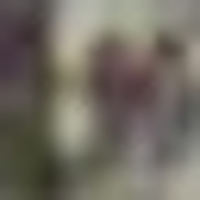

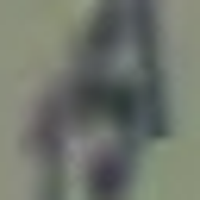

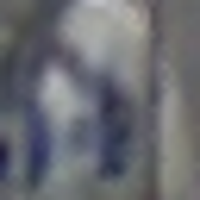

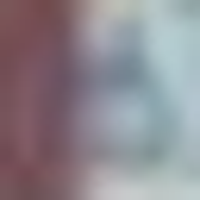

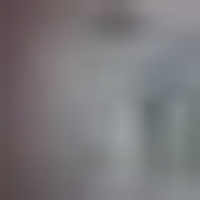

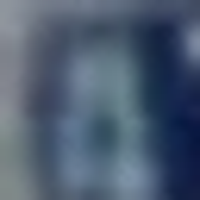

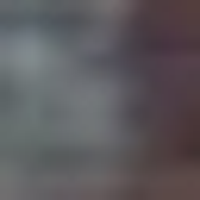

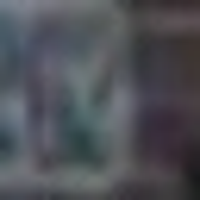

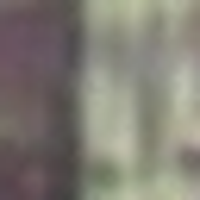

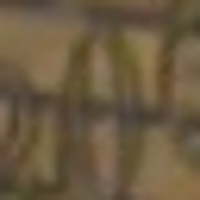

In [84]:
from PIL import Image
for i in map(lambda x: x[0], sorted(enumerate(np.max(np.sum(test_ds, axis=-1), axis=-1)), key=lambda x: x[1])[:10]):
    display(Image.fromarray(np.uint8(a[i])).resize((200, 200)))

In [85]:
final_ans = np.argmax(model_acc.predict(test_ds), axis=-1)
ans = pd.DataFrame({'Id': np.arange(final_ans.shape[0]), 'Category': final_ans})
ans.to_csv('../answers/ensemble_g_9_acc.csv', index=False)

782/782 [==============================] - 2s 2ms/step


In [86]:
final_ans = np.argmax(model_loss.predict(test_ds), axis=-1)
ans = pd.DataFrame({'Id': np.arange(final_ans.shape[0]), 'Category': final_ans})
ans.to_csv('../answers/ensemble_g_9_loss.csv', index=False)

782/782 [==============================] - 3s 3ms/step


In [87]:
final_ans = np.argmax(model_avg_acc.predict(test_ds), axis=-1)
ans = pd.DataFrame({'Id': np.arange(final_ans.shape[0]), 'Category': final_ans})
ans.to_csv('../answers/ensemble_g_9_avg_acc.csv', index=False)

782/782 [==============================] - 2s 3ms/step


In [88]:
final_ans = np.argmax(model_avg_loss.predict(test_ds), axis=-1)
ans = pd.DataFrame({'Id': np.arange(final_ans.shape[0]), 'Category': final_ans})
ans.to_csv('../answers/ensemble_g_9_avg_loss.csv', index=False)

782/782 [==============================] - 2s 2ms/step
